In [52]:
import numpy as np
from scipy.signal import lfilter, butter
import pandas as pd
from sklearn.decomposition import FastICA
import matplotlib.pyplot as plt
from scipy.stats import kurtosis

In [53]:
def load_subject_data(subject, start_series, end_series):
    ''' Loads the data or events specified as filetype for a subject. The series
    are specified to build a training and testing sets. '''
    keep_channels =['Fp1', 'Fp2', 
                'F7', 'F3', 'Fz', 'F4', 'F8', 
                'FC5', 'FC6', 
                'T7', 'C3', 'C4', 'T8', 
                'CP5', 'CP6',
                'P7', 'P3', 'P4', 'P8', 
                'O1', 'Oz', 'O2']
    path = r'C:/Users/tomry/Documents/EEG/train/'
    series = range(start_series, end_series+1)
    subject_data = []
    for serie in series:
        data_filename = path + 'subj%d_series%d_data.csv' % (subject, serie)
        data = pd.read_csv(data_filename)
        data = data.loc[:, keep_channels]
        subject_data.append(data)
    subj_data = pd.concat(subject_data)
    return subj_data.to_numpy()

In [54]:
subject = 1
x_train = load_subject_data(subject, 1, 6)

In [55]:
def causal_filt(x, cutoffs, fs=500, btype='bandpass'):
    ''' Applies a causal IIR filter to x. '''
    b, a = butter(4, cutoffs, fs=fs, btype=btype)
    x_filtered = lfilter(b, a, x, axis=0)
    return x_filtered

def downsample(x, n=3, start=0):
    ''' Downsamples the signals in x by taking every nth sample. '''
    return x[start::n, :]

def decimate(x):
    ''' Decimate the signal by filtering and downsampling. '''
    x = causal_filt(x, [0.5, 80])
    x = downsample(x)
    return x

In [56]:
x_train_processed = decimate(x_train)

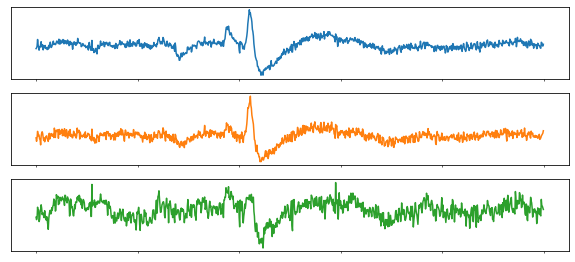

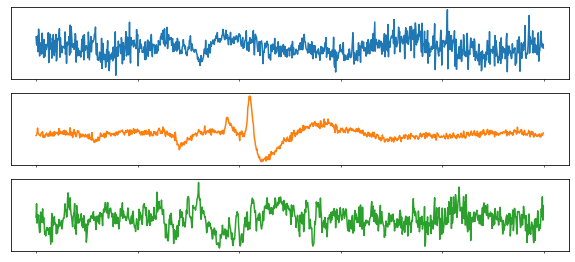

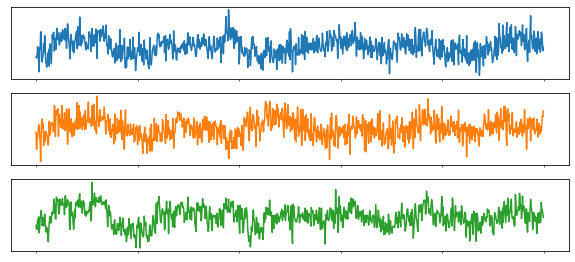

In [68]:
def hjorth_mobility(x):
    ''' Column-wise computation of Hjorth mobility'''
    return np.sqrt(np.var(np.gradient(x, axis=0), axis=0)/np.var(x, axis=0)).reshape(1,-1)

def hjorth_complexity(x):
    ''' Column-wise computation of Hjorth complexity'''
    return hjorth_mobility(np.gradient(x, axis=0)) / hjorth_mobility(x).reshape(1,-1)

def detect_blink_peak(x):
    max_val = np.max(np.absolute(x))
    if max_val >= 0.01:
        return True
    else:
        return False
    
def remove_blinks(x):
    ica = FastICA(tol=0.01, max_iter=500).fit(x)
    x_ica = ica.transform(x) # applies unmixing matrix to x
    win_length = 200
    fs = 500/3
    for i, col in enumerate(x_ica.T): # iterate columns
        num_blinks = 0
        
        for j in range(0, len(col)-win_length, win_length):
            window = col[j:j+win_length] # window through signal
            is_blink = detect_blink_peak(window) # detect blink in window
        
            # count number of blinks
            if is_blink:
                num_blinks += 1
        
        # compute kurtosis of whole signal
        kur = kurtosis(col)
        
        # compute hjorth complexity
        comp = hjorth_complexity(col)[0][0]
        
        # blink artifact source decision rule
        if num_blinks >= len(x_ica)/(fs*40) and kur > 5 and comp > 3:
            # FOR PLOTTING
            ica_df = pd.DataFrame(data=x_ica[:,i-1:i+2])
            ica_df.iloc[1000:2000,:].plot(subplots=True, figsize=(10,5), legend=False, xticks=[], yticks=[])
            plt.show()
            x_ica[:, i] = 0
    
    # apply inverse transformation
    x_clean = ica.inverse_transform(x_ica)
    
    return x_clean

x_df = pd.DataFrame(data=x_train_processed[:,0:3])
x_df.iloc[1000:2000,:].plot(subplots=True, figsize=(10,5), legend=False, xticks=[], yticks=[])
plt.show()

x_clean = remove_blinks(x_train_processed)

x_df_clean = pd.DataFrame(data=x_clean[:,0:3])
x_df_clean.iloc[1000:2000,:].plot(subplots=True, figsize=(10,5), legend=False, xticks=[], yticks=[])
plt.show()

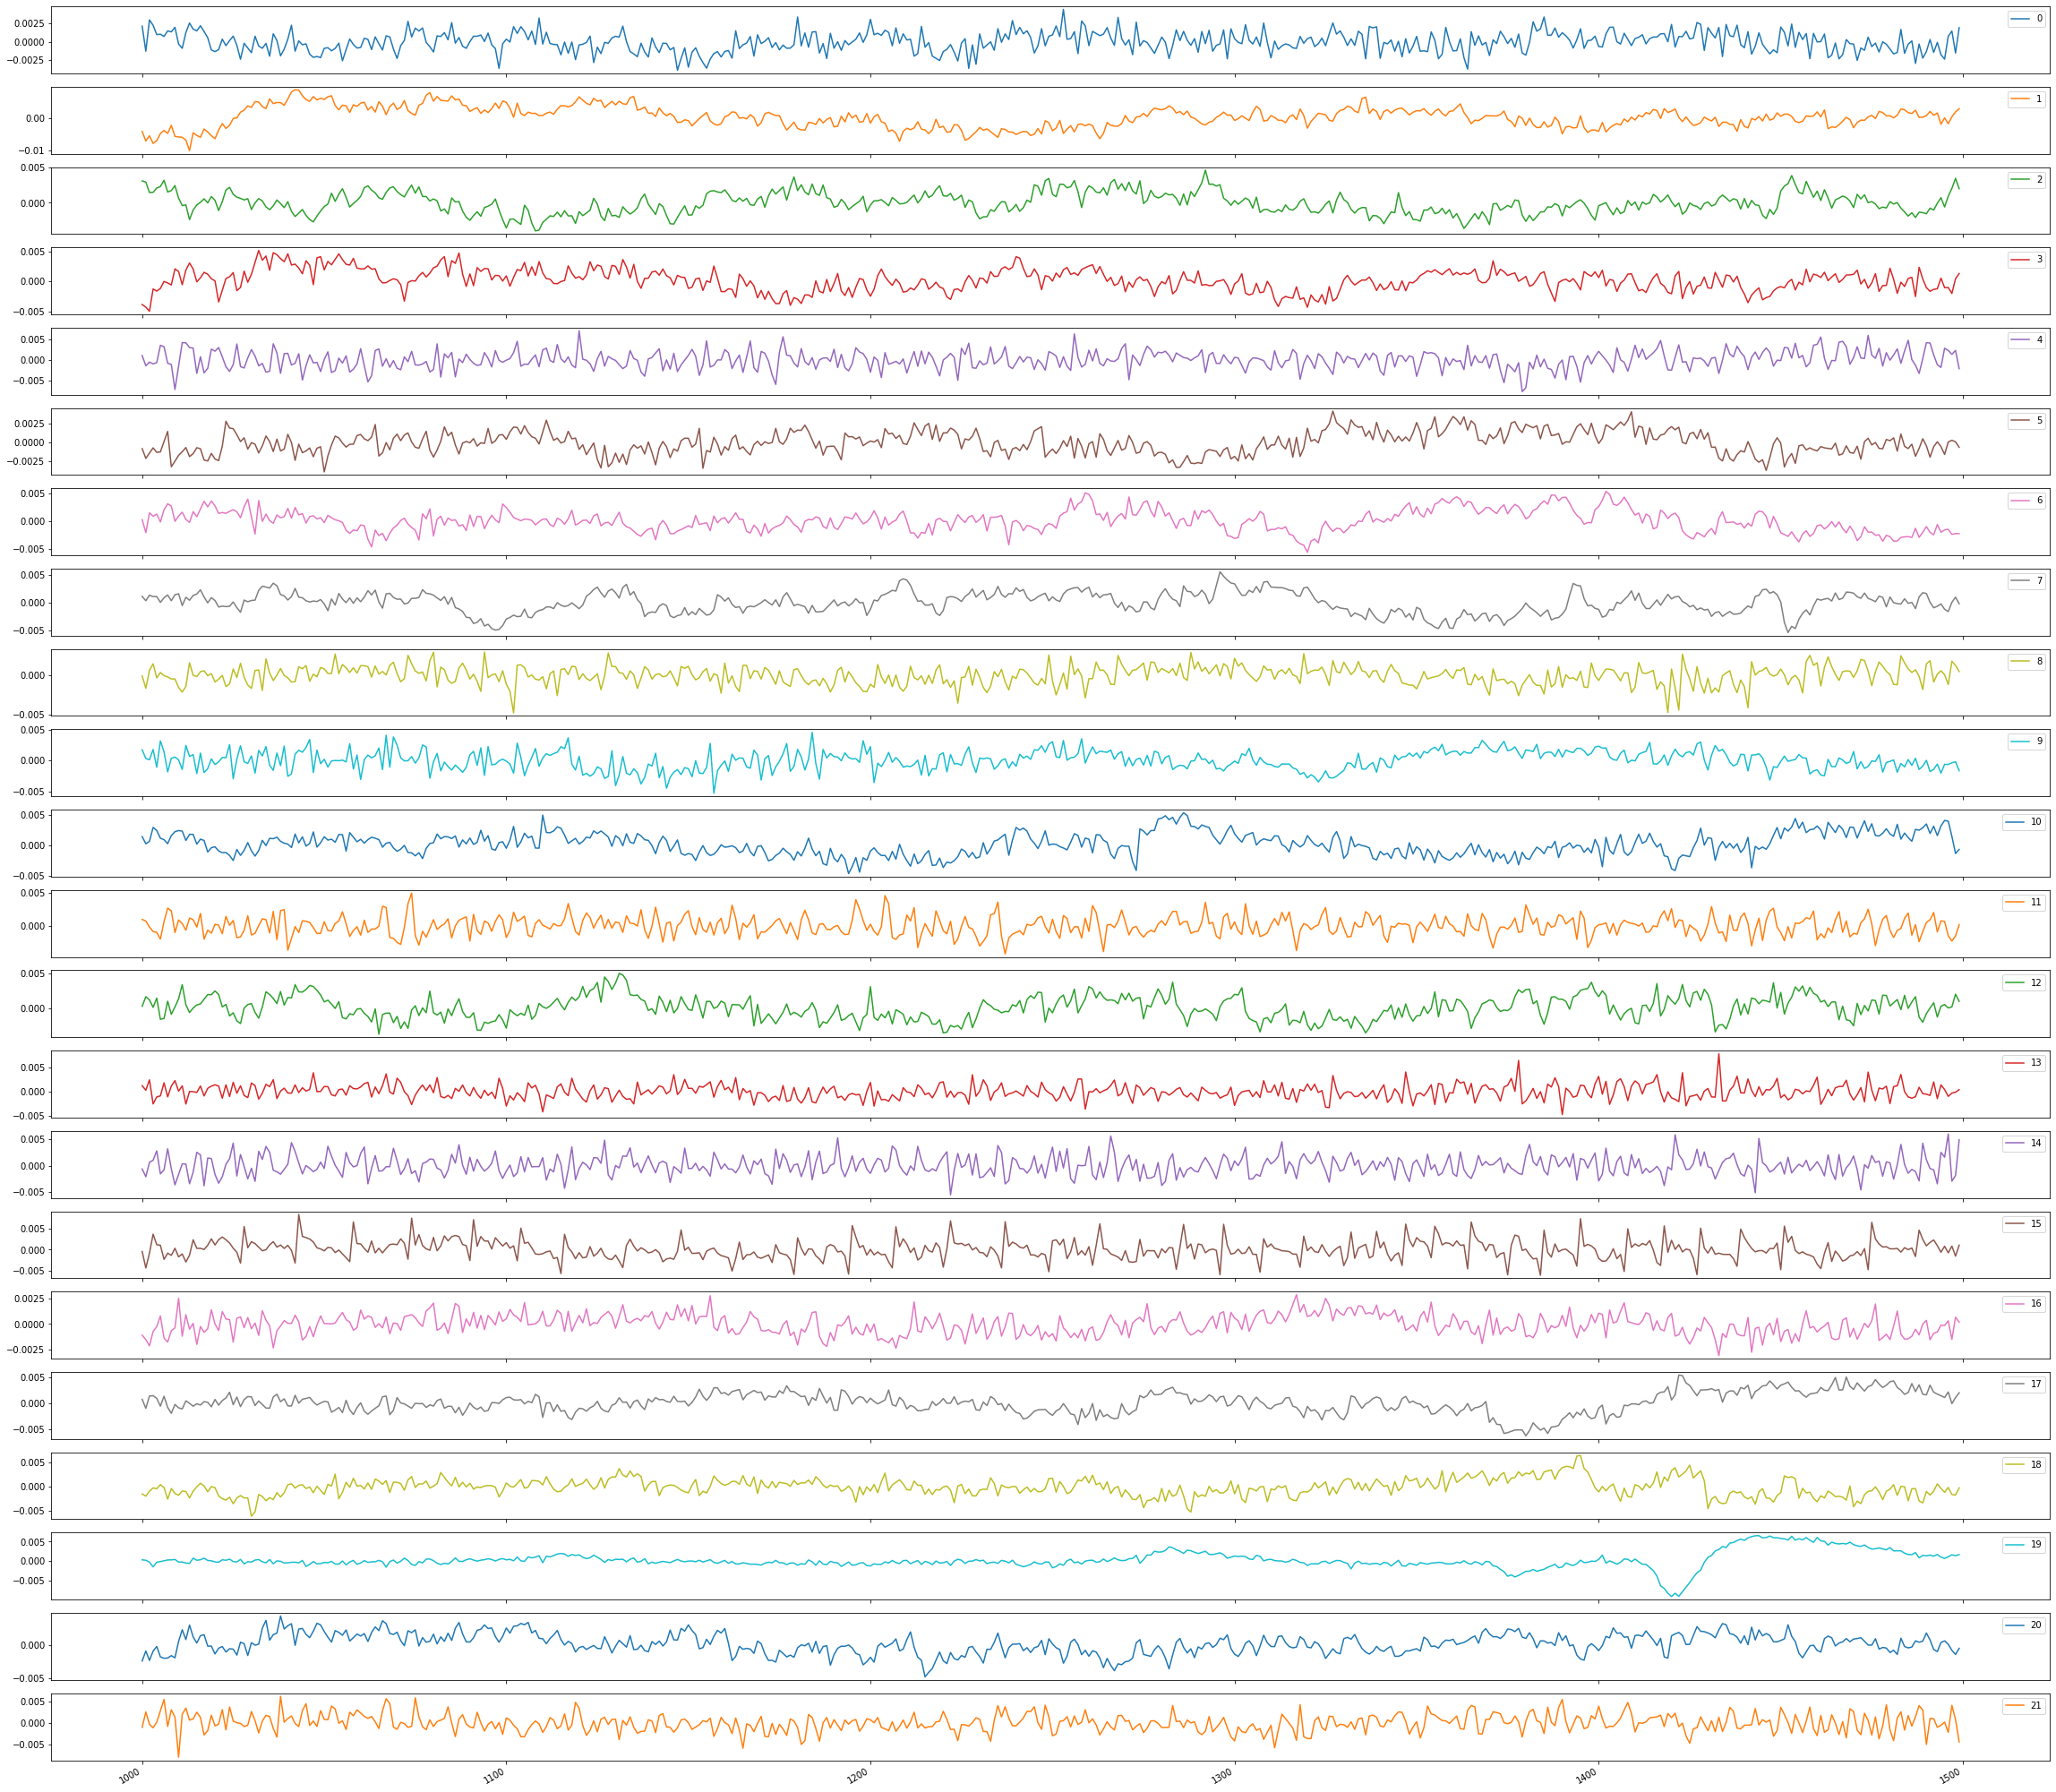

In [51]:
ica = FastICA().fit(x_train_processed)
independent_sources = ica.transform(x_train_processed)
# plot channels for manual inspection
independent_sources_df = pd.DataFrame(data=independent_sources)
#independent_sources_df.iloc[1000:3000,:].plot(subplots=True, figsize=(40,40))
#plt.show()
independent_sources_df.iloc[1000:1500,:].plot(subplots=True, figsize=(40,40))
plt.show()

In [21]:
independent_sources[:, 1] = 0
x_clean = ica.inverse_transform(independent_sources)

In [64]:
def plot_(x, a, b=1):
    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15,10))
    
    ax[0].plot(x[2000:int(a*b),0], 'b')
    ax[0].set_ylim([-1000,3200])
    ax[0].set_xticklabels([])
    ax[0].set_yticklabels([])
    
    ax[1].plot(x[2000:int(a*b),1], 'orange')
    ax[1].set_ylim([-1000,3200])
    ax[1].set_xticklabels([])
    ax[1].set_yticklabels([])
    
    ax[2].plot(x[2000:int(a*b),2], 'g') 
    ax[2].set_ylim([-1000,3200])
    ax[2].set_xticklabels([])
    ax[2].set_yticklabels([])

    plt.show()

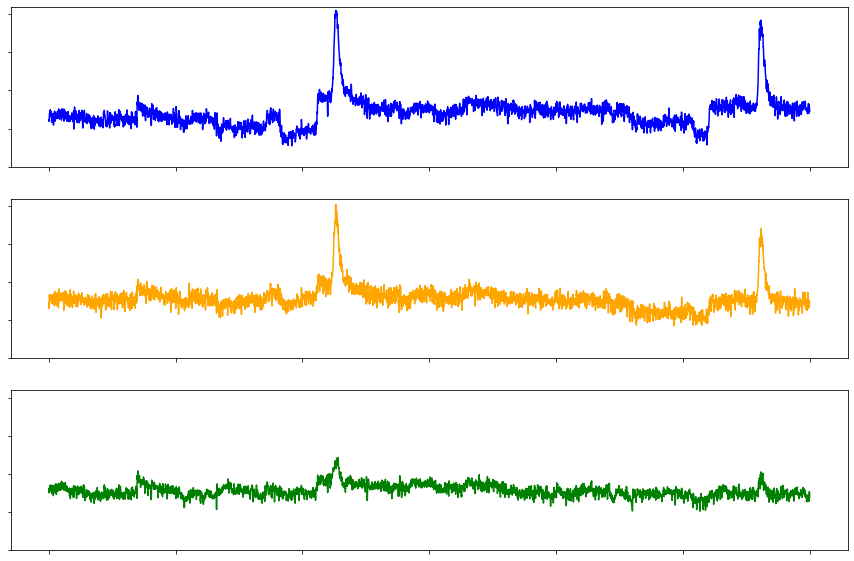

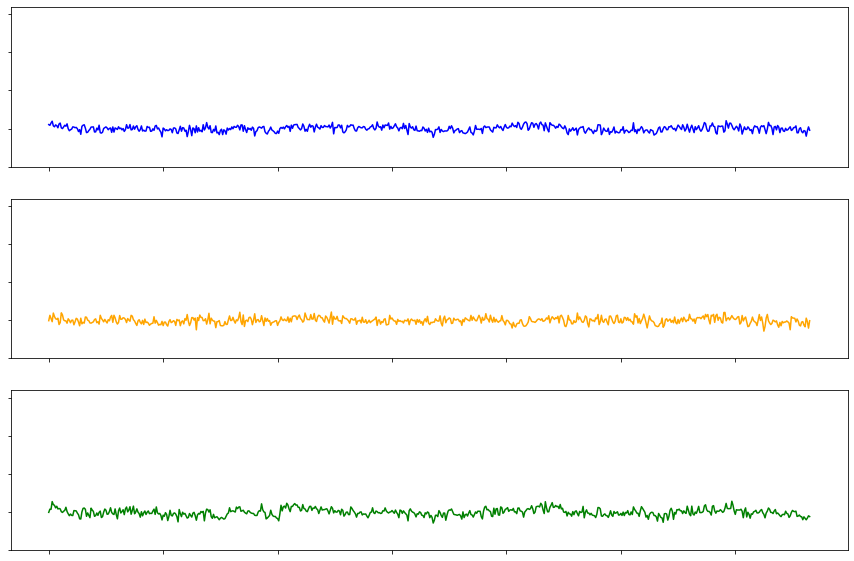

In [65]:
plot_(x_train, a=8000)
plot_(x_clean, a=8000, b=1/3)